In [ ]:
!pip install torchsummary

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from torchsummary import summary
from torch.autograd import Variable
from torchvision import transforms, datasets

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH // 3  # 1:3 ratio
NUM_CLASSES = 78
EPOCHS = 100

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
    ]
)

In [4]:
from google.colab import drive
drive.mount('./drive/')
!unzip './drive/MyDrive/province.zip' -d './dataset'

Mounted at ./drive/
Archive:  ./drive/MyDrive/province.zip
   creating: ./dataset/province/
   creating: ./dataset/province/000เชียงใหม่/
  inflating: ./dataset/province/000เชียงใหม่/20220530015914356_317_G1_3_LPRF3_30_LPR_2_Province.png  
  inflating: ./dataset/province/000เชียงใหม่/20220530071142820_317_G1_4_LPRF4_38_LPR_2_Province.png  
  inflating: ./dataset/province/000เชียงใหม่/20220530072655378_317_G1_4_LPRF4_86_LPR_2_Province.png  
  inflating: ./dataset/province/000เชียงใหม่/20220530073037198_317_G1_3_LPRF3_104_LPR_2_Province.png  
  inflating: ./dataset/province/000เชียงใหม่/20220530075037619_317_G1_1_LPRF1_81_LPR_2_Province.png  
  inflating: ./dataset/province/000เชียงใหม่/20220530081637513_317_G1_1_LPRF1_29_LPR_2_Province.png  
  inflating: ./dataset/province/000เชียงใหม่/20220530085433429_317_G1_3_LPRF3_278_LPR_2_Province.png  
  inflating: ./dataset/province/000เชียงใหม่/20220530092020460_317_G1_1_LPRF1_58_LPR_2_Province.png  
  inflating: ./dataset/province/000เชียงใหม่

In [5]:
# Add empty folder check to ImageFolder
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        try:
            super().__init__(root=root, transform=transform)
        except FileNotFoundError as e:
            print(f"Warning: {e}")
            print("Continuing with available classes...")
            super().__init__(root=root, transform=transform, is_valid_file=lambda x: True, allow_empty=True)

In [6]:
training_set_path = "./dataset/province"

train_split = 0.8
full_training_set = CustomImageFolder(root=training_set_path, transform=transform)
train_size = int(train_split * len(full_training_set))
test_size = len(full_training_set) - train_size
training_set, validation_set = torch.utils.data.random_split(
    full_training_set, [train_size, test_size]
)

training_loader = torch.utils.data.DataLoader(
    training_set, batch_size=BATCH_SIZE, shuffle=True
)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=BATCH_SIZE, shuffle=False
)

print("Training set has {} instances".format(len(training_set)))
print("Validation set has {} instances".format(len(validation_set)))

Training set has 3261 instances
Validation set has 816 instances


In [7]:
class_labels = full_training_set.classes
class_labels_index = full_training_set.class_to_idx
print("Number of Classes:", len(class_labels))
print("Class Labels:", class_labels)
print("Class Labels Index:", class_labels_index)

Number of Classes: 78
Class Labels: ['000เชียงใหม่', '001นครราชสีมา', '002กาญจนบุรี', '003ตาก', '004อุบลราชธานี', '005สุราษฎร์ธานี', '006ชัยภูมิ', '007แม่ฮ่องสอน', '008เพชรบูรณ์', '009ลำปาง', '010อุดรธานี', '011เชียงราย', '012น่าน', '013เลย', '014ขอนแก่น', '015พิษณุโลก', '016บุรีรัมย์', '017นครศรีธรรมราช', '018สกลนคร', '019นครสวรรค์', '020ศรีสะเกษ', '021กำแพงเพชร', '022ร้อยเอ็ด', '023สุรินทร์', '024อุตรดิตถ์', '025สงขลา', '026สระแก้ว', '027กาฬสินธุ์', '028อุทัยธานี', '029สุโขทัย', '030แพร่', '031ประจวบคีรีขันธ์', '032จันทบุรี', '033พะเยา', '034เพชรบุรี', '035ลพบุรี', '036ชุมพร', '037นครพนม', '038สุพรรณบุรี', '039มหาสารคาม', '040ฉะเชิงเทรา', '041ราชบุรี', '042ตรัง', '043ปราจีนบุรี', '044กระบี่', '045พิจิตร', '046ยะลา', '047ลำพูน', '048นราธิวาส', '049ชลบุรี', '050มุกดาหาร', '051บึงกาฬ', '052พังงา', '053ยโสธร', '054หนองบัวลำภู', '055สระบุรี', '056ระยอง', '057พัทลุง', '058ระนอง', '059อำนาจเจริญ', '060หนองคาย', '061ตราด', '062พระนครศรีอยุธยา', '063สตูล', '064ชัยนาท', '065นครปฐม', '066นครนาย

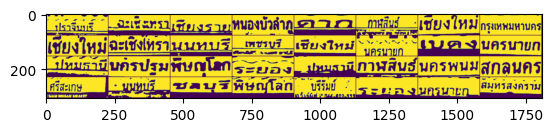

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=True):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [9]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [10]:
def count_model_param_flops(model=None, input_res_h = 224, input_res_w = 224, multiply_adds=True):

    prods = {}

    def save_hook(name):
        def hook_per(self, input, output):
            prods[name] = np.prod(input[0].shape)

        return hook_per

    list_1 = []

    def simple_hook(self, input, output):
        list_1.append(np.prod(input[0].shape))

    list_2 = {}

    def simple_hook2(self, input, output):
        list_2["names"] = np.prod(input[0].shape)

    list_conv = []

    def conv_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = (
            self.kernel_size[0] * self.kernel_size[1] * (self.in_channels / self.groups)
        )
        bias_ops = 1 if self.bias is not None else 0

        params = output_channels * (kernel_ops + bias_ops)
        # flops = (kernel_ops * (2 if multiply_adds else 1) + bias_ops) * output_channels * output_height * output_width * batch_size

        num_weight_params = (self.weight.data != 0).float().sum()
        flops = (
            (
                num_weight_params * (2 if multiply_adds else 1)
                + bias_ops * output_channels
            )
            * output_height
            * output_width
            * batch_size
        )

        list_conv.append(flops)

    list_linear = []

    def linear_hook(self, input, output):
        batch_size = input[0].size(0) if input[0].dim() == 2 else 1

        weight_ops = self.weight.nelement() * (2 if multiply_adds else 1)
        bias_ops = self.bias.nelement()

        flops = batch_size * (weight_ops + bias_ops)
        list_linear.append(flops)

    list_bn = []

    def bn_hook(self, input, output):
        list_bn.append(input[0].nelement() * 2)

    list_relu = []

    def relu_hook(self, input, output):
        list_relu.append(input[0].nelement())

    list_pooling = []

    def pooling_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size * self.kernel_size
        bias_ops = 0
        params = 0
        flops = (
            (kernel_ops + bias_ops)
            * output_channels
            * output_height
            * output_width
            * batch_size
        )

        list_pooling.append(flops)

    list_upsample = []

    # For bilinear upsample
    def upsample_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        flops = output_height * output_width * output_channels * batch_size * 12
        list_upsample.append(flops)

    def foo(net):
        childrens = list(net.children())
        if not childrens:
            if isinstance(net, torch.nn.Conv2d):
                net.register_forward_hook(conv_hook)
            if isinstance(net, torch.nn.Linear):
                net.register_forward_hook(linear_hook)
            if isinstance(net, torch.nn.BatchNorm2d):
                net.register_forward_hook(bn_hook)
            if isinstance(net, torch.nn.ReLU):
                net.register_forward_hook(relu_hook)
            if isinstance(net, torch.nn.MaxPool2d) or isinstance(
                net, torch.nn.AvgPool2d
            ):
                net.register_forward_hook(pooling_hook)
            if isinstance(net, torch.nn.Upsample):
                net.register_forward_hook(upsample_hook)
            return
        for c in childrens:
            foo(c)

    if model == None:
        model = torchvision.models.alexnet()
    foo(model)
    input = Variable(
        torch.rand(3, input_res_h, input_res_w).unsqueeze(0), requires_grad=True
    )
    out = model(input)

    total_flops = (
        sum(list_conv)
        + sum(list_linear)
        + sum(list_bn)
        + sum(list_relu)
        + sum(list_pooling)
        + sum(list_upsample)
    )

    print(
        "Number of FLOPs: %.6f GFLOPs (%.2f MFLOPs)"
        % (total_flops / 1e9, total_flops / 1e6)
    )

    return total_flops

In [11]:
class Model(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(Model, self).__init__()
        self.model = models.resnet50(weights="DEFAULT")
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


model = Model().to(device)

summary(model, (3, IMAGE_HEIGHT, IMAGE_WIDTH))
count_model_param_flops(
    model=model.to("cpu").eval(), input_res_h = IMAGE_HEIGHT, input_res_w = IMAGE_WIDTH, multiply_adds=True
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 100MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 37, 112]           9,408
       BatchNorm2d-2          [-1, 64, 37, 112]             128
              ReLU-3          [-1, 64, 37, 112]               0
         MaxPool2d-4           [-1, 64, 19, 56]               0
            Conv2d-5           [-1, 64, 19, 56]           4,096
       BatchNorm2d-6           [-1, 64, 19, 56]             128
              ReLU-7           [-1, 64, 19, 56]               0
            Conv2d-8           [-1, 64, 19, 56]          36,864
       BatchNorm2d-9           [-1, 64, 19, 56]             128
             ReLU-10           [-1, 64, 19, 56]               0
           Conv2d-11          [-1, 256, 19, 56]          16,384
      BatchNorm2d-12          [-1, 256, 19, 56]             512
           Conv2d-13          [-1, 256, 19, 56]          16,384
      BatchNorm2d-14          [-1, 256,

tensor(2.9986e+09)

In [12]:
model = Model().to(device)
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


epoch_number = 0
path_save_cp = "./"
best_vloss = 1_000_000.0
training_logs = {
    "train_loss": [],
    "train_acc": [],
    "validate_loss": [],
    "validate_acc": [],
}

In [13]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

patience = 5
min_delta = 0.001
best_vloss = float("inf")
epochs_no_improve = 0
t_0_accelerated = time.time()

for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    model.train(True)

    for i, data in enumerate(training_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    model.eval()
    valid_loss, valid_correct = 0, 0

    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()

        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(
            valid_correct / len(validation_loader.dataset)
        )

    if epoch % 1 == 0:
        print(
            f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",
            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
        )
        print("-" * 80)

    if valid_loss < best_vloss - min_delta:
        best_vloss = valid_loss
        epochs_no_improve = 0
        if not os.path.exists(path_save_cp):
            os.mkdir(path_save_cp)
        model_dict = {
            'state_dict': model.state_dict(),
            'class_mapping': full_training_set.class_to_idx
        }
        torch.save(model_dict, path_save_cp + "Province_ResNet50.pth")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience and epoch > 50:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

t_end_accelerated = time.time() - t_0_accelerated
print(
    f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec"
)

Epochs 1   train loss 2.21163 train acc 0.50567 validate loss 0.60966 validate acc 0.86275
--------------------------------------------------------------------------------
Epochs 2   train loss 0.31676 train acc 0.91966 validate loss 0.73428 validate acc 0.81127
--------------------------------------------------------------------------------
Epochs 3   train loss 0.11646 train acc 0.96811 validate loss 0.09489 validate acc 0.97426
--------------------------------------------------------------------------------
Epochs 4   train loss 0.07447 train acc 0.98007 validate loss 0.21103 validate acc 0.93995
--------------------------------------------------------------------------------
Epochs 5   train loss 0.05421 train acc 0.98681 validate loss 0.18027 validate acc 0.95956
--------------------------------------------------------------------------------
Epochs 6   train loss 0.01804 train acc 0.99724 validate loss 0.04689 validate acc 0.98897
-------------------------------------------------

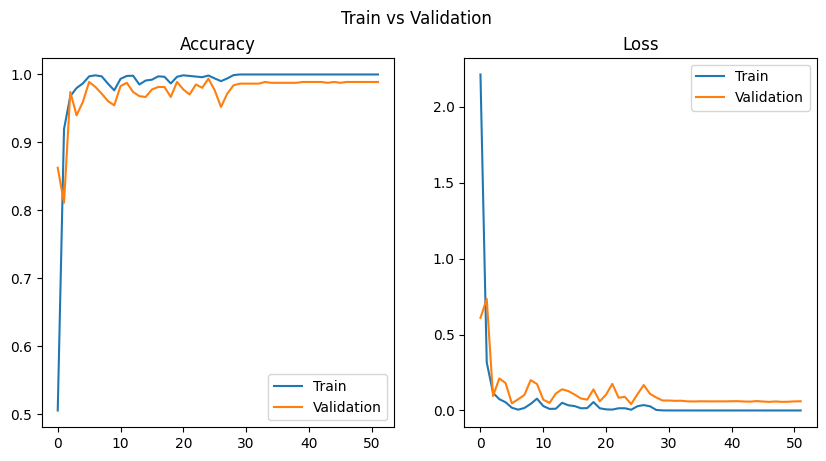

In [14]:
plot_graph(training_logs)

In [15]:
PATH = "./Province_ResNet50.pth"
checkpoint = torch.load(PATH, map_location=torch.device("cpu"))
loaded_model = model
loaded_model.load_state_dict(checkpoint['state_dict'])
acc_test = 0
test_loss = 0
loaded_model.to(device).eval()
stored_lbs = torch.empty(0, dtype=torch.float32).to(device)
stored_preds = torch.empty(0, dtype=torch.float32).to(device)
t_0_accelerated = time.time()

with torch.no_grad():
    for i, tdata in enumerate(validation_loader):
        tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
        toutputs = loaded_model(tinputs)
        loss = loss_fn(toutputs, tlabels)
        test_loss += loss
        _, preds_t = torch.max(toutputs, 1)
        acc_test += (preds_t == tlabels).float().mean().item()
        stored_lbs = torch.cat((stored_lbs, tlabels), 0)
        stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
t_end_accelerated = time.time() - t_0_accelerated
print(
    "[(test loss: {}] [accuracy_test: {} %]".format(
        avg_tloss, accuracy_t * 100
    )
)
print(
    f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec"
)

<ipython-input-15-5186d6f09c20>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH, map_location=torch.device("cpu"))


[(test loss: 0.041993897408246994] [accuracy_test: 99.4 %]
Time consumption for accelerated CUDA training (device:cuda): 18.772228717803955 sec


In [16]:
from sklearn.metrics import (
    precision_recall_fscore_support,
    normalized_mutual_info_score,
    adjusted_rand_score,
)

lb = stored_lbs.cpu()
prd = stored_preds.cpu()

# ---F1-score/Precision/Recall scores
print(
    "Precision/Recall/F-beta score:",
    precision_recall_fscore_support(
        lb, prd, average="weighted", zero_division=0, beta=1.0
    ),
)

# ---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(
    labels_true=lb,
    labels_pred=prd,
    average_method="arithmetic",
)

# ---Rand Index (RI) score
ri_score = adjusted_rand_score(
    labels_true=lb,
    labels_pred=prd,
)

print(f"NMI score: {nmi_score}, RI score: {ri_score}")

Precision/Recall/F-beta score: (0.9941635938391994, 0.9938725490196079, 0.993804644306156, None)
NMI score: 0.9954433719254993, RI score: 0.9899800571907974


#### onnx

In [17]:
!pip install onnx
!pip install onnxscript
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.6/691.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


In [18]:
import onnx
import onnxruntime as ort

In [19]:
def inspect_onnx_model(model_path):
    # Load ONNX model
    model = onnx.load(model_path)

    # Print model inputs
    print("\nModel Inputs:")
    for input in model.graph.input:
        print(f"Name: {input.name}")
        print(f"Shape: {[d.dim_value for d in input.type.tensor_type.shape.dim]}")

    # Print model outputs
    print("\nModel Outputs:")
    for output in model.graph.output:
        print(f"Name: {output.name}")
        print(f"Shape: {[d.dim_value for d in output.type.tensor_type.shape.dim]}")

    # Create an inference session to get more details
    session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])

    print("\nDetailed Input Info:")
    for i in session.get_inputs():
        print(f"Name: {i.name}")
        print(f"Shape: {i.shape}")
        print(f"Type: {i.type}")

    print("\nDetailed Output Info:")
    for o in session.get_outputs():
        print(f"Name: {o.name}")
        print(f"Shape: {o.shape}")
        print(f"Type: {o.type}")

In [20]:
from PIL import Image

def test_single_image(image_path, model_path, class_mapping):
    # Initialize ONNX Runtime session
    session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image)
    input_data = image_tensor.unsqueeze(0).numpy()

    # Run inference
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: input_data.astype(np.float32)})
    probabilities = outputs[0][0]

    # Get top predictions
    top_indices = np.argsort(probabilities)[-5:][::-1]  # Get top 5

    print("\nPredictions:")
    for idx in top_indices:
        print(f"Index {idx}: Class {[k for k,v in class_mapping.items() if v == idx][0]}, "
              f"Probability: {probabilities[idx]:.4f}")

    return probabilities

In [21]:
checkpoint = torch.load('Province_ResNet50.pth')
torch_model = Model()
torch_model.load_state_dict(checkpoint['state_dict'])
class_mapping = checkpoint['class_mapping']
torch_model.eval()
torch_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)

input_names = ["input"]
output_names = ["output"]
dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}

torch.onnx.export(torch_model,
                  torch_input,
                  "Province_ResNet50.onnx",
                  export_params=True,
                  opset_version=14,
                  do_constant_folding=False,
                  input_names=input_names,
                  output_names=output_names,
                  dynamic_axes=dynamic_axes,
                  keep_initializers_as_inputs=False,
                  )

<ipython-input-21-459d614be45e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('Province_ResNet50.pth')


In [22]:
session = ort.InferenceSession("Province_ResNet50.onnx", providers=['CPUExecutionProvider'])

input_name = session.get_inputs()[0].name
dummy_input = np.random.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH).astype(np.float32)

# Warmup run
session.run(None, {input_name: dummy_input})

# Benchmark
num_runs = 1000
start_time = time.time()
for _ in range(num_runs):
    output = session.run(None, {input_name: dummy_input})
end_time = time.time()

avg_inference_time = (end_time - start_time) / num_runs
fps = 1 / avg_inference_time

print(f"Average Inference Time on CPU: {avg_inference_time * 1000:.2f} ms")
print(f"FPS (Frames Per Second): {fps:.2f}")

Average Inference Time on CPU: 53.92 ms
FPS (Frames Per Second): 18.55


In [23]:
model_path = "Province_ResNet50.onnx"
inspect_onnx_model(model_path)


Model Inputs:
Name: input
Shape: [0, 3, 74, 224]

Model Outputs:
Name: output
Shape: [0, 78]

Detailed Input Info:
Name: input
Shape: ['batch_size', 3, 74, 224]
Type: tensor(float)

Detailed Output Info:
Name: output
Shape: ['batch_size', 78]
Type: tensor(float)


In [24]:
# Test with a known image
test_single_image('./drive/MyDrive/test/24_02_05_V00490_Province.png', 'Province_ResNet50.onnx', class_mapping)


Predictions:
Index 68: Class 068กรุงเทพมหานคร, Probability: 13.8160
Index 70: Class 070สมุทรปราการ, Probability: 0.6880
Index 37: Class 037นครพนม, Probability: -3.7583
Index 62: Class 062พระนครศรีอยุธยา, Probability: -5.6028
Index 72: Class 072สมุทรสาคร, Probability: -5.8894


array([-21.340816  , -14.5875    , -13.896841  , -30.639074  ,
       -14.189438  , -16.488062  , -33.41926   , -12.531817  ,
       -17.83129   , -34.935448  , -30.817019  , -20.784874  ,
       -40.93595   , -33.108925  ,  -8.961794  , -18.13036   ,
       -34.683655  ,  -8.637421  , -19.30051   , -16.693893  ,
       -15.135624  ,  -6.1177645 , -18.721817  , -17.370043  ,
       -21.03331   , -21.361519  , -21.735203  , -23.22251   ,
       -23.582834  , -22.37405   , -26.95131   , -16.181263  ,
       -11.385053  , -17.212788  , -16.404675  , -21.088299  ,
       -12.402616  ,  -3.7583373 , -12.256068  , -10.505266  ,
       -11.107534  , -18.354202  , -47.9935    , -27.181616  ,
       -35.127296  , -35.296555  , -31.02795   , -13.788642  ,
       -34.671963  , -34.03383   , -11.058658  , -22.560076  ,
       -36.77677   , -39.71777   , -15.225302  , -35.77975   ,
       -27.142738  , -20.999426  , -10.60163   , -12.398814  ,
        -7.2004113 , -19.159214  ,  -5.602841  , -31.70